In [2]:
import os
from glob import glob
import cv2
import open3d as o3d
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


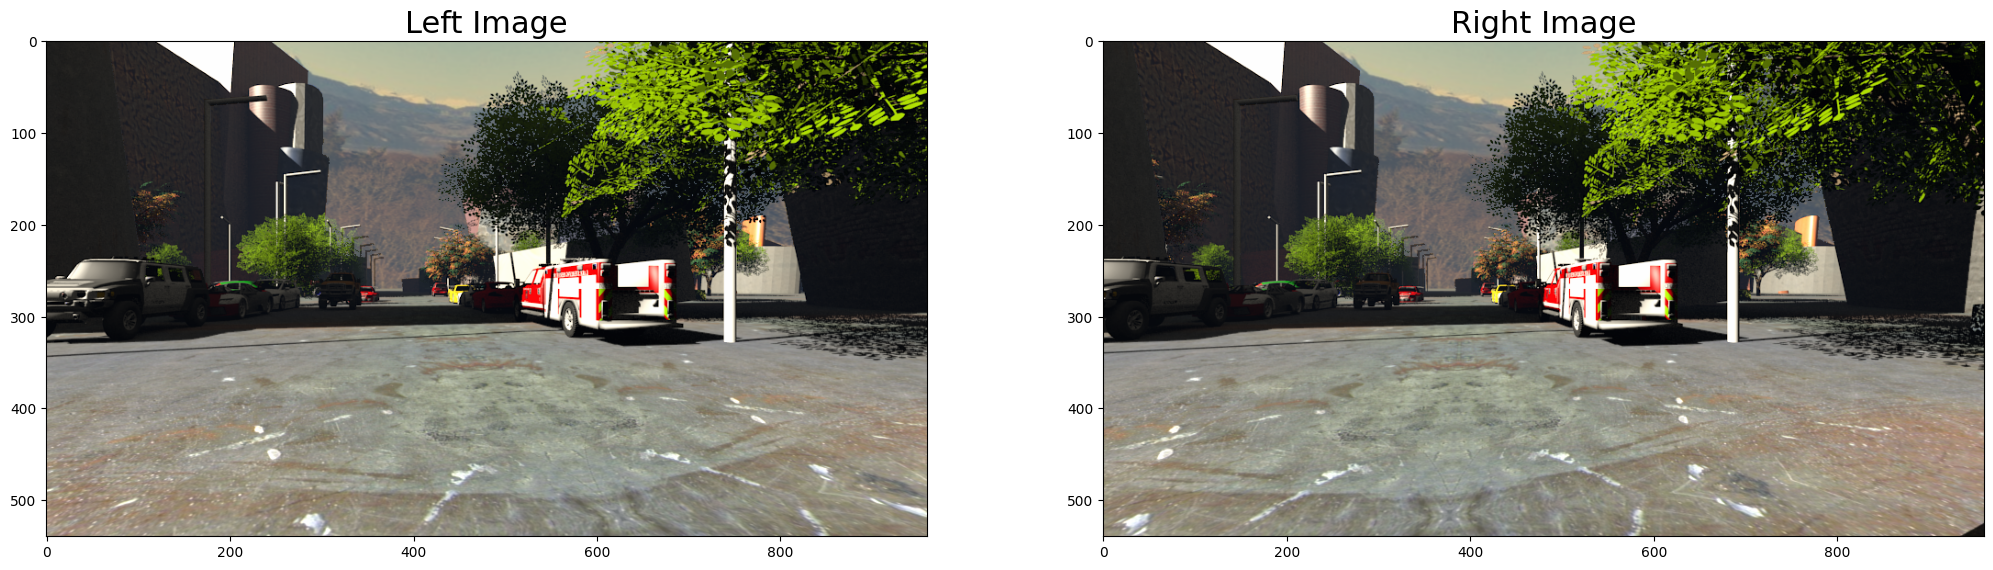

In [3]:
DATA_PATH = r'/media/joseph/Development/SFITC/FlyingThings3D/Sampler/Driving/'

left_image_paths = sorted(glob(os.path.join(DATA_PATH, 'RGB_cleanpass/left/*.png')))
right_image_paths = sorted(glob(os.path.join(DATA_PATH, 'RGB_cleanpass/right/*.png')))

index = 0

left_image = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)
right_image = cv2.cvtColor(cv2.imread(right_image_paths[index]), cv2.COLOR_BGR2RGB)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 15))
ax1.imshow(left_image)
ax1.set_title('Left Image', size=22)
ax2.imshow(right_image)
ax2.set_title('Right Image', size=22);

In [163]:
def get_krt(path):
    df = pd.read_csv(path, sep=' ', index_col=False)

    K = np.array([[725, 0, 620.5],
                [0, 725, 187.0],
                [0, 0, 1]])

    frame_data = []

    for index, row in df.iterrows():
        # Extract R and T values from the row and format them correctly
        R = np.array([[row['r1,1'], row['r1,2'], row['r1,3']],
                    [row['r2,1'], row['r2,2'], row['r2,3']],
                    [row['r3,1'], row['r3,2'], row['r3,3']]])

        T = np.array([row['t1'], row['t2'], row['t3'], 1])

        # Append the K, R, and T matrices for the frame to the list
        frame_data.append([K, R, T])
        
    return frame_data
    
    
K_left, R_left, T_left = get_krt(f'{DATA_PATH}/vkitti_1.3.1_extrinsicsgt/0001_15-deg-left.txt')[index]
K_right, R_right, T_right = get_krt(f'{DATA_PATH}/vkitti_1.3.1_extrinsicsgt/0001_15-deg-right.txt')[index]

Number of left images: 447
Number of right images: 447
Number of LiDAR point clouds: 447


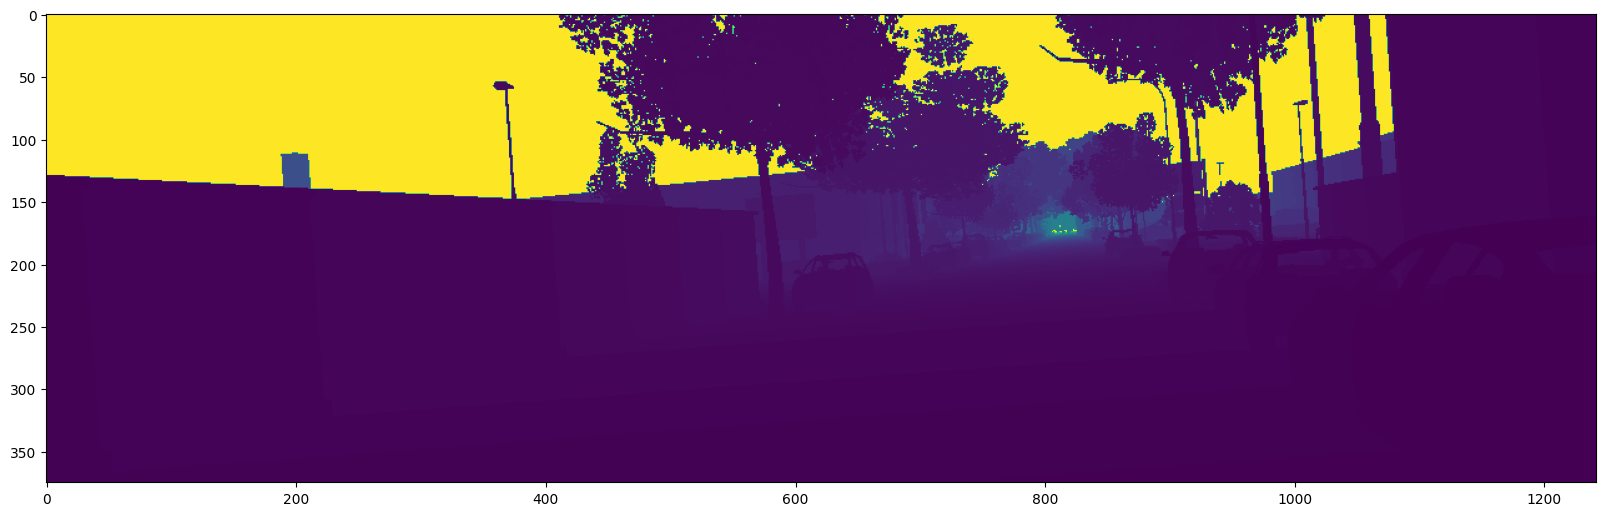

In [159]:
bin_paths = sorted(glob(os.path.join(DATA_PATH, 'vkitti_1.3.1_depthgt/0001/15-deg-left/*.png')))

lidar_depth_map = cv2.imread(bin_paths[index], cv2.IMREAD_ANYDEPTH)

print(f"Number of left images: {len(left_image_paths)}")
print(f"Number of right images: {len(right_image_paths)}")
print(f"Number of LiDAR point clouds: {len(bin_paths)}")

plt.imshow(lidar_depth_map);

In [147]:
print(f"The shape of an image is: {left_image.shape}")

The shape of an image is: (375, 1242, 3)


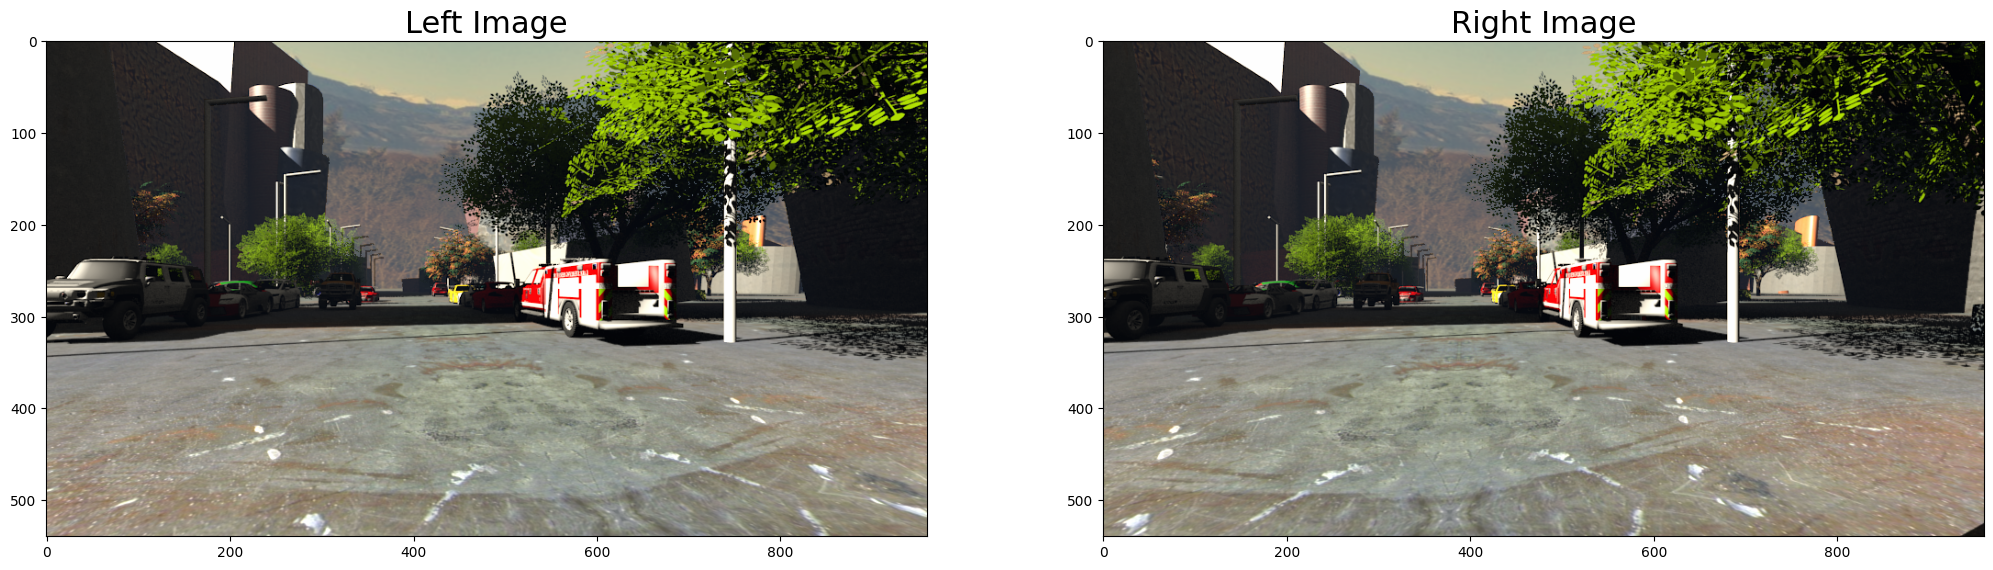

In [4]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 15))
ax1.imshow(left_image)
ax1.set_title('Left Image', size=22)
ax2.imshow(right_image)
ax2.set_title('Right Image', size=22);

In [5]:
def compute_sgbm_disparity(left_image, right_image, num_disparities=5*16, 
                           block_size=11, window_size=5, display=False):
    """ Computes the disparity of an image pair using the SGBM algoithm.
        Inputs: 
            image_left/_right - (MxN) grayscale input images
            see opencv documentation for "StereoBM_create"
        Outputs:
            disparity (MxN) computed disparity map for the input images
        
        NOTE: image_left must be the left image (same for the right) or 
              unexpected results will occur due to 
    """
    # P1 and P2 control disparity smoothness (recommended values below)
    P1 = 8 * 3 * window_size**2
    P2 = 32 * 3 * window_size**2
    sgbm_obj = cv2.StereoSGBM_create(0, num_disparities, block_size, 
        P1, P2, mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY)
        
    # compute disparity
    disparity = sgbm_obj.compute(left_image, right_image).astype(np.float32)/16.0

    # display is desired
    if display:
      plt.figure(figsize = (40,20))
      plt.imshow(disparity, cmap='cividis')
      plt.title('Disparity Map', size=25)
      plt.show();

    return disparity

def calc_depth_map(disp_left, K_left, T_left, T_right):
    ''' Computes Depth map from Intrinsic Camera Matrix and Translations vectors.
        For KITTI, the depth is in meters.
        '''
    # Get the focal length from the K matrix
    f = K_left[0, 0]
    
    # Get the distance between the cameras from the t matrices (baseline)
    b = np.abs(T_left[0] - T_right[0])[0]
    
    # Replace all instances of 0 and -1 disparity with a small minimum value (to avoid div by 0 or negatives)
    disp_left[disp_left <= 0] = 1e-5
    
    # Calculate the depths 
    depth_map = f*b / disp_left 

    return depth_map

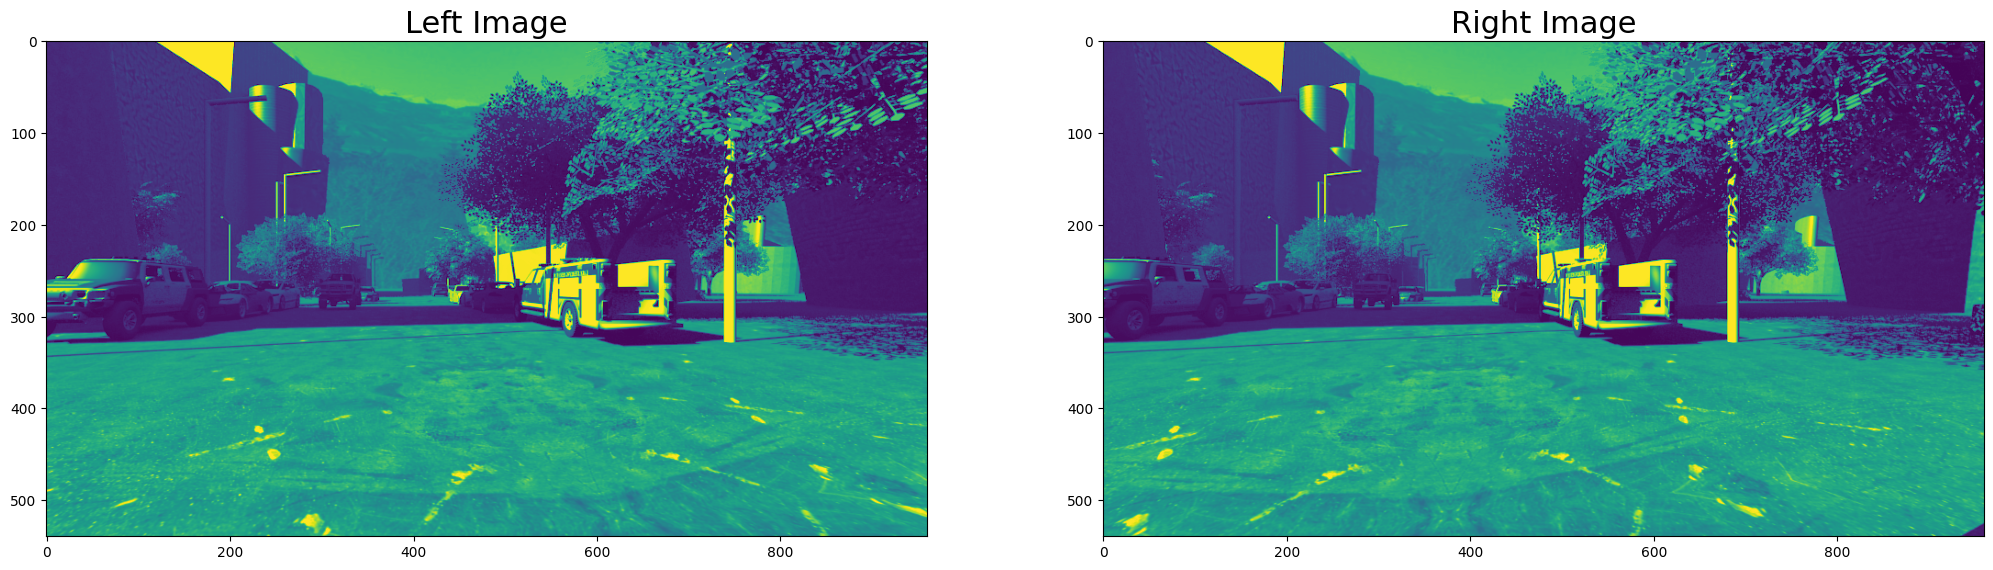

In [6]:
left_image_gray = cv2.cvtColor(left_image, cv2.COLOR_RGB2GRAY)
right_image_gray = cv2.cvtColor(right_image, cv2.COLOR_RGB2GRAY)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 15))
ax1.imshow(left_image_gray)
ax1.set_title('Left Image', size=22)
ax2.imshow(right_image_gray)
ax2.set_title('Right Image', size=22);

In [14]:
from IPython.display import Image
from ipywidgets import interact, interactive, fixed

disparity = interactive(compute_sgbm_disparity, 
                        left_image=fixed(left_image_gray), 
                        right_image=fixed(right_image_gray), 
                        num_disparities=(0,512,16), 
                        block_size=(1,19,2), 
                        window_size=(1,13,2),
                        display=fixed(True))
display(disparity)

interactive(children=(IntSlider(value=80, description='num_disparities', max=512, step=16), IntSlider(value=11…

In [16]:
# num_disparities = disparity.kwargs['num_disparities']
# block_size = disparity.kwargs['block_size']
# window_size = disparity.kwargs['window_size']
num_disparities = 160
block_size = 11
window_size = 11

In [17]:
disparity = compute_sgbm_disparity(left_image_gray, 
                                   right_image_gray, 
                                   num_disparities, 
                                   block_size, 
                                   window_size, 
                                   display=False)

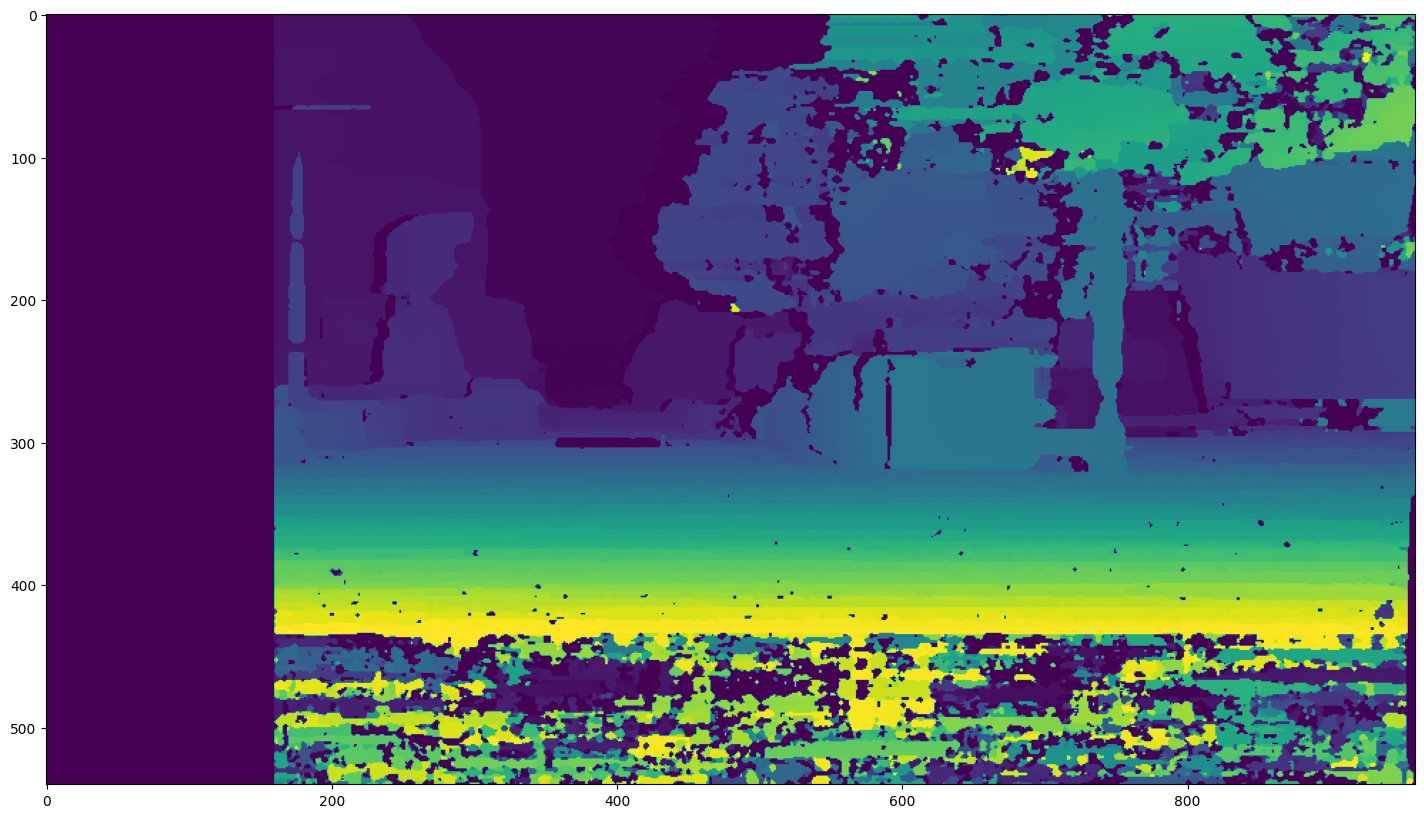

In [18]:
plt.imshow(disparity)

In [160]:
stereo_depth_map = calc_depth_map(disparity, K_left, T_left, T_right)
# stereo_depth_map[stereo_depth_map > 38000000.0] = np.NAN

plt.imshow(stereo_depth_map, cmap='rainbow_r'); # or 'cividis_r' or 'cividis'

IndexError: invalid index to scalar variable.

## Overlapping

In [18]:
lidar_depth_map.shape

(375, 1242)

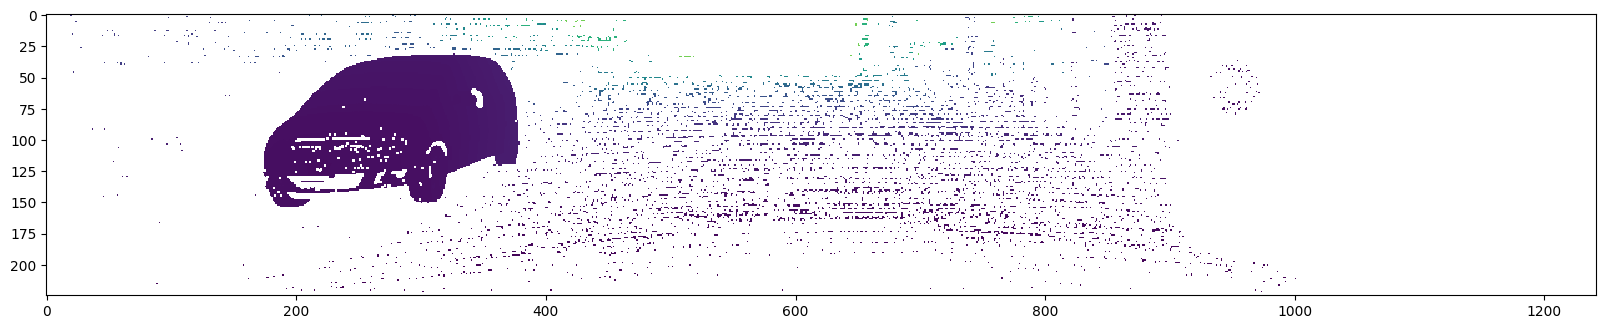

In [19]:
# TODO: Make this dynamic

plt.imshow(lidar_depth_map[150:,:])

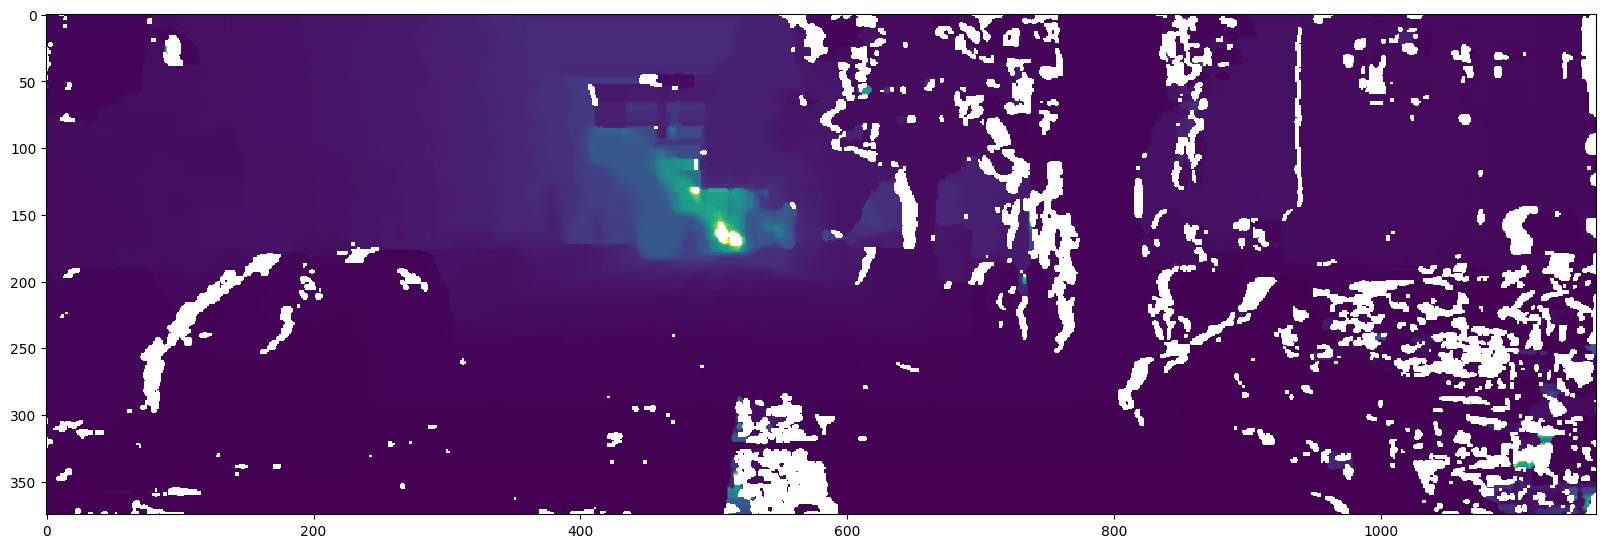

In [20]:
plt.imshow(stereo_depth_map[:,80:])

## Point Cloud

In [21]:
def depth_map_to_point_cloud(depth_map, flip=True):
    # Convert the depth map to Open3D depth image
    depth_image_o3d = o3d.geometry.Image(depth_map.astype(np.float32))

    # Create an Intrinsics object using camera parameters
    height, width = depth_map.shape
    fx, fy = K_left[0, 0], K_left[1, 1]
    cx, cy = K_left[0, 2], K_left[1, 2]
    intrinsic = o3d.camera.PinholeCameraIntrinsic(
        width, height, fx, fy, cx, cy)

    # Create a point cloud from the depth image
    point_cloud = o3d.geometry.PointCloud.create_from_depth_image(
        depth_image_o3d, 
        intrinsic,
        # depth_scale=1,
        # depth_trunc=0.00070
    )

    if flip:
        point_cloud.transform([
            [1, 0, 0, 0],
            [0, -1, 0, 0],
            [0, 0, -1, 0],
            [0, 0, 0, 1]
        ])

    return point_cloud


def rgbd_to_point_cloud(color, depth_map, flip=True):
    # Convert the depth map to Open3D depth image
    depth_image_o3d = o3d.geometry.Image(depth_map.astype(np.float32))

    # Convert the depth map to Open3D depth image
    color_image_o3d = o3d.geometry.Image(color)

    # Create RGBD image
    rgbd_image_o3d = o3d.geometry.RGBDImage.create_from_color_and_depth(
        color_image_o3d, 
        depth_image_o3d,
        depth_scale=1,
        depth_trunc=70
        )

    # Create an Intrinsics object using camera parameters
    height, width = depth_map.shape
    fx, fy = K_left[0, 0], K_left[1, 1]
    cx, cy = K_left[0, 2], K_left[1, 2]
    intrinsic = o3d.camera.PinholeCameraIntrinsic(
        width, height, fx, fy, cx, cy)

    # Create a point cloud from the depth image
    point_cloud = o3d.geometry.PointCloud.create_from_rgbd_image(
        rgbd_image_o3d, intrinsic)

    if flip:
        point_cloud.transform([
            [1, 0, 0, 0],
            [0, -1, 0, 0],
            [0, 0, -1, 0],
            [0, 0, 0, 1]
        ])

    return point_cloud

# Visualize the point cloud
o3d.visualization.draw_geometries([
    # depth_map_to_point_cloud(stereo_depth_map),
    depth_map_to_point_cloud(lidar_depth_map),
    rgbd_to_point_cloud(left_image, stereo_depth_map),
])

## PG Implementation

176983
20346
0


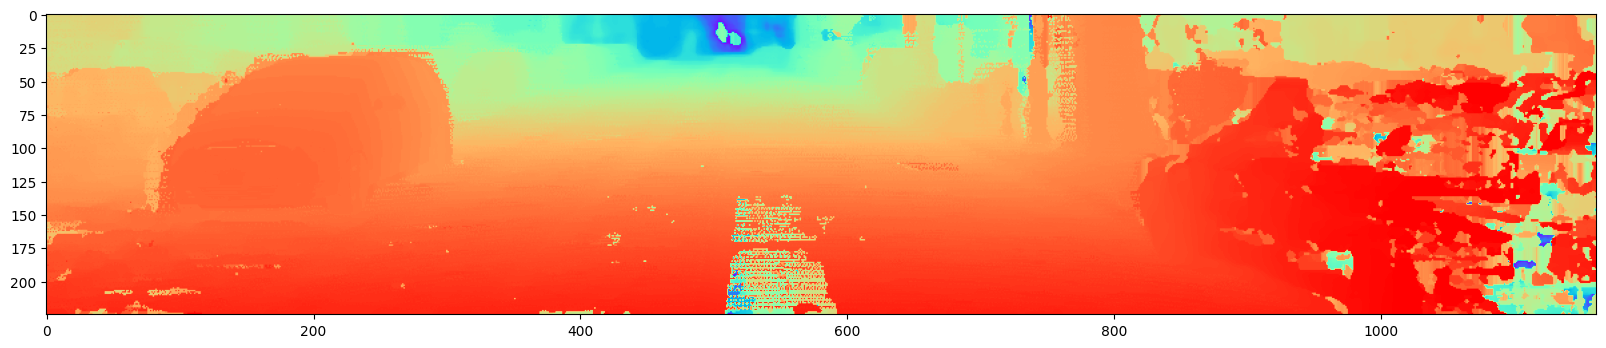

In [22]:
import cupy as cp

# vlp_depth = cp.array(lidar_depth_map)
# zed_depth = cp.array(stereo_depth_map)
# rgb = cp.array(left_image)
vlp_depth = cp.array(lidar_depth_map[150:,80:])
zed_depth = cp.array(stereo_depth_map[150:,80:])
rgb = cp.array(left_image[150:,80:])

def fillB_withA(A, B):
    # Combine A and B, prioritizing non-NaN values in A
    combined = cp.where(cp.isnan(A), B, A)

    # Calculate the column-wise means of the combined matrix, ignoring NaNs
    col_means = cp.nanmean(combined, axis=0)

    # Replace NaN values in the combined matrix with the column-wise means
    combined = cp.where(cp.isnan(combined), col_means, combined)
    
    return combined

print(cp.count_nonzero(cp.isnan(vlp_depth)))
print(cp.count_nonzero(cp.isnan(zed_depth)))

mask = cp.isnan(zed_depth)

# zed_depth = cp.array(cv2.inpaint(zed_depth.get(), mask.get().astype(np.uint8), 3, cv2.INPAINT_TELEA))

# zed_depth[cp.isnan(zed_depth)] = vlp_depth.mean()
# zed_depth[cp.isnan(zed_depth)] = vlp_depth.max()
# zed_depth[cp.isnan(zed_depth)] = vlp_depth.min()
# zed_depth[zed_depth > 2000] = vlp_mean

zed_depth = fillB_withA(vlp_depth, zed_depth)

print(cp.count_nonzero(cp.isnan(zed_depth)))

plt.imshow(np.log(zed_depth.get()), cmap='rainbow_r');

/tmp/ipykernel_17901/4080190018.py:70: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(pg_depth.get() - zed_depth.get()), cmap='rainbow_r')
/tmp/ipykernel_17901/4080190018.py:70: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(pg_depth.get() - zed_depth.get()), cmap='rainbow_r')


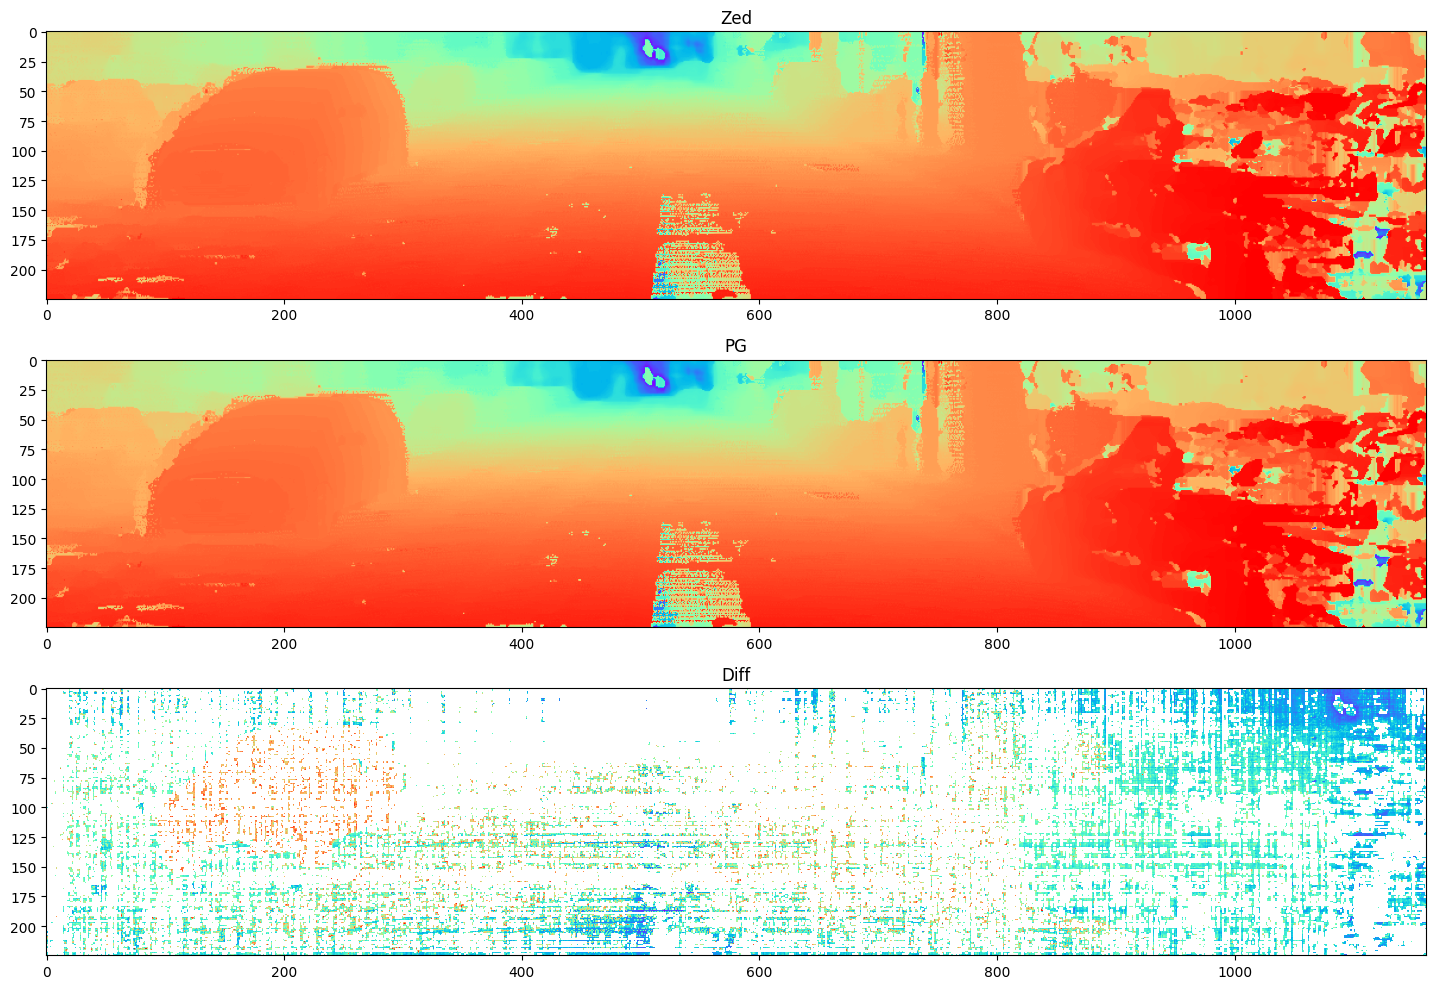

In [23]:
def lpf(img, ncutoff):
    # Apply 2D FFT to the image
    f = cp.fft.fft2(img)

    # Shift the zero frequency component to the center of the spectrum
    fshift = cp.fft.fftshift(f)

    # Create a circular mask of the same size as the spectrum
    rows, cols = img.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.zeros((rows, cols), np.uint8)
    cutoff = int(min(crow, ccol)*ncutoff)
    cv2.circle(mask, (ccol, crow), cutoff, 1, -1)
    # cv2.ellipse(mask, (ccol, crow), (1, 2) * cutoff, 0, 0, 360,  1, -1)

    mask = cp.asarray(mask)

    # Apply the mask to the shifted spectrum
    fshift_filtered = fshift * mask

    # Shift the zero frequency component back to the corner of the spectrum
    f_filtered = cp.fft.ifftshift(fshift_filtered)

    # Apply the inverse 2D FFT to the filtered spectrum
    img_filtered = cp.fft.ifft2(f_filtered)
    img_filtered = cp.real(img_filtered)

    return img_filtered


def pg(zed_depth, vlp_depth, ncutoff, threshold=100):
    mask = vlp_depth > 0
    filtered = zed_depth

    while threshold > 0:
        filtered[mask] = vlp_depth[mask]
        filtered = lpf(filtered, ncutoff)

        threshold -= 1
        # ncutoff = ncutoff / 10

    return filtered


pg_depth = pg(
    cp.array(zed_depth.copy()),
    cp.array(vlp_depth.copy()),
    # cp.log(cp.array(zed_depth.copy())),
    # cp.log(cp.array(vlp_depth.copy())),
    ncutoff=10,
    threshold=100
)

# pg_depth = cp.exp(pg_depth)
# pg_depth[mask] = cp.NAN

# plt.imshow(pg_depth.get(), cmap='rainbow_r')
# plt.imshow(np.log(pg_depth.get()), cmap='rainbow_r')
# plt.imshow(np.exp(pg_depth.get()), cmap='rainbow_r')

plt.subplot(3, 1, 1)
plt.imshow(np.log(zed_depth.get()), cmap='rainbow_r')
plt.title('Zed')

plt.subplot(3, 1, 2)
plt.imshow(np.log(pg_depth.get()), cmap='rainbow_r')
plt.title('PG')

plt.subplot(3, 1, 3)
plt.imshow(np.log(pg_depth.get() - zed_depth.get()), cmap='rainbow_r')
plt.title('Diff')

plt.tight_layout()
plt.show()

In [24]:
# Visualize the point cloud
o3d.visualization.draw_geometries([
    # depth_map_to_point_cloud(zed_depth.get()),
    # rgbd_to_point_cloud(rgb.get(), zed_depth.get()),
    depth_map_to_point_cloud(vlp_depth.get()),
    rgbd_to_point_cloud(rgb.get(), pg_depth.get()),
    # depth_map_to_point_cloud(pg_depth.get()),
])


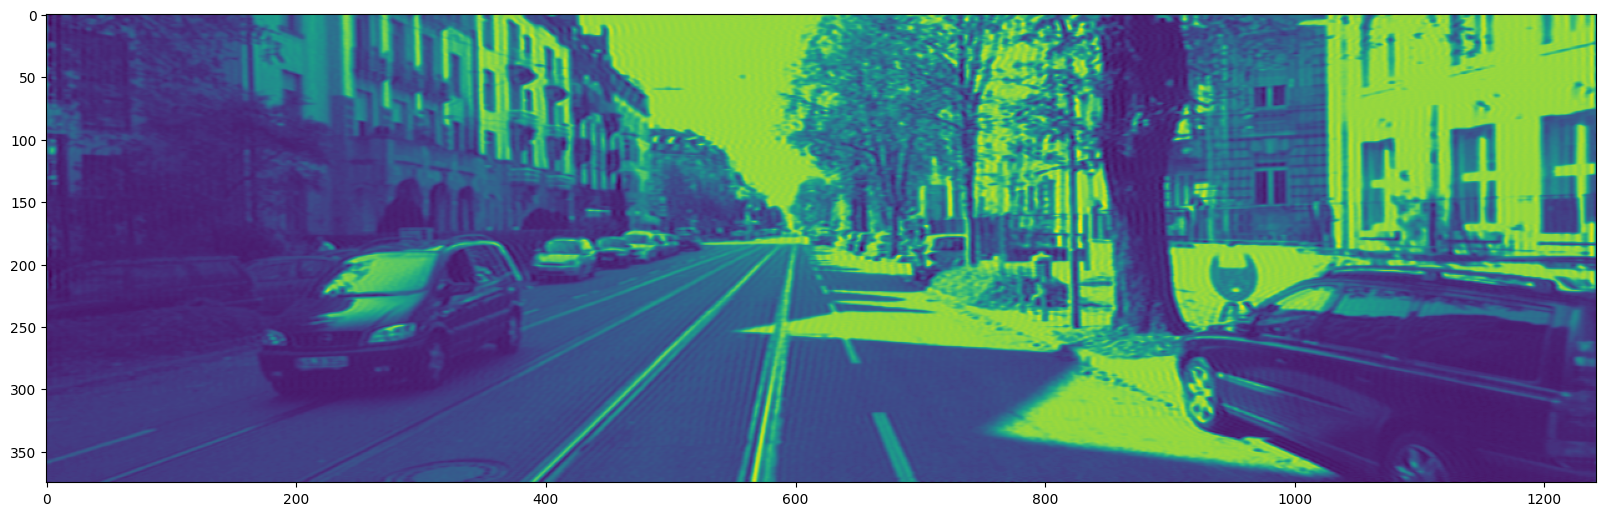

In [25]:
left_image_filtered = cp.array(left_image_gray)
for i in range(100):
    left_image_filtered = lpf(left_image_filtered, ncutoff=1)
plt.imshow(left_image_filtered.get())

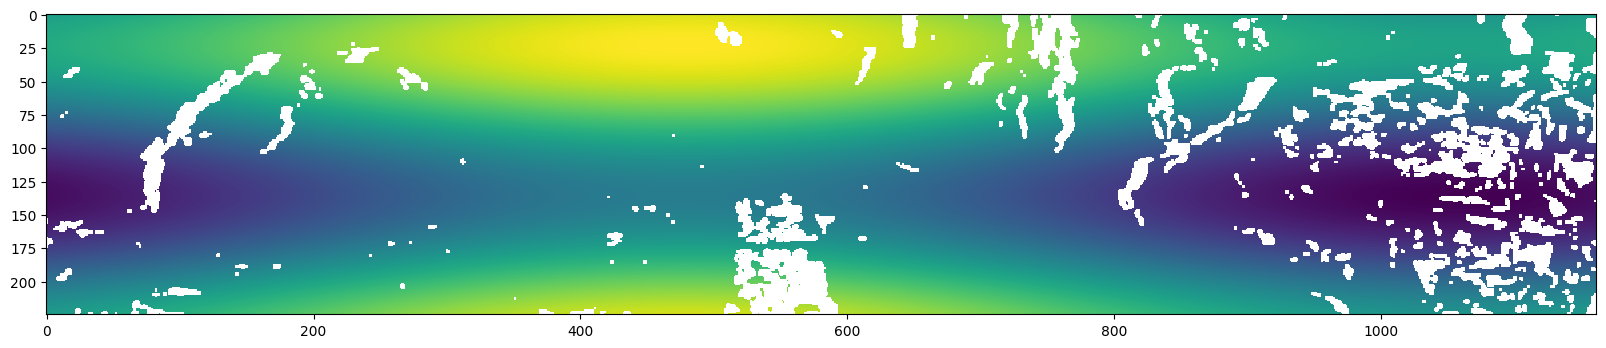

In [26]:
filtered = cp.array(zed_depth)
for i in range(1):
    filtered = lpf(filtered, ncutoff=0.01)
    
filtered[mask] = cp.NAN
    
plt.imshow(filtered.get())

o3d.visualization.draw_geometries([
    rgbd_to_point_cloud(rgb.get(), filtered.get()),
    # depth_map_to_point_cloud(np.log(filtered.get())),
])

nan

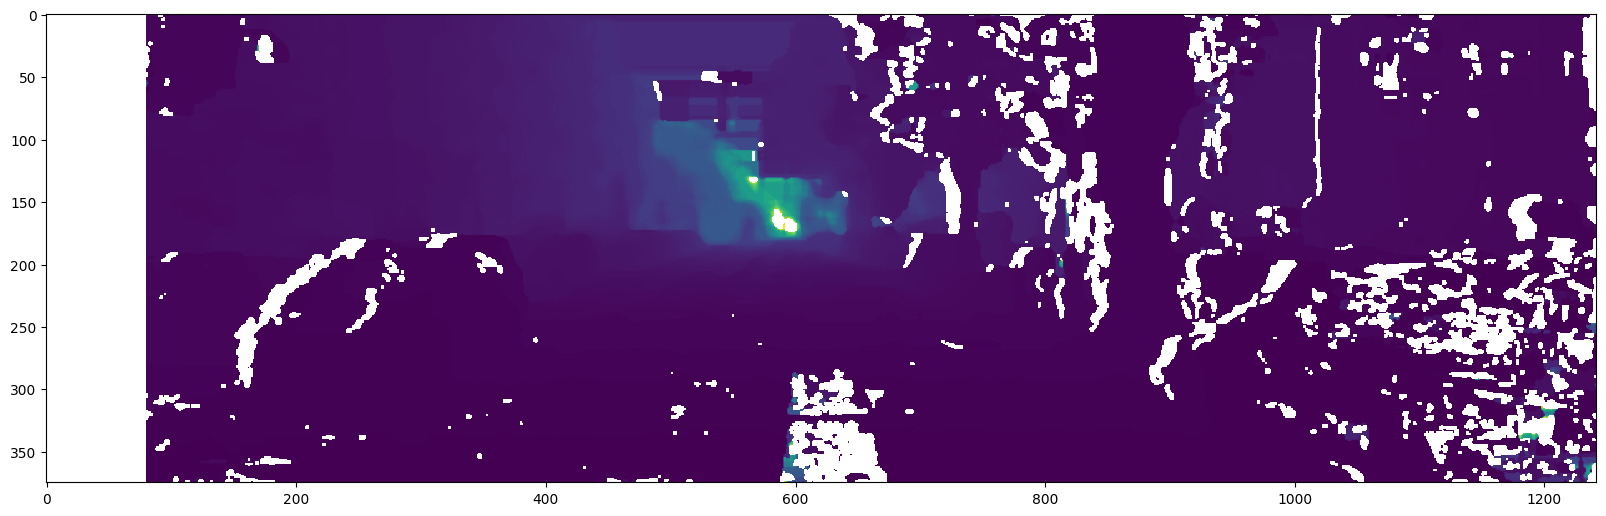

In [27]:
mask = (stereo_depth_map == 0).astype(np.uint8) * 255
filled_depth_map = cv2.inpaint(stereo_depth_map, mask, 3, cv2.INPAINT_TELEA)

plt.imshow(filled_depth_map)
filled_depth_map.min()

## Purposed Fill Method

In [28]:
np.array([
    [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
    [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
    [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
    [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
    [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
    [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
    [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
    [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
])

A = np.array([
    [np.nan, 1, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
    [np.nan, 2, np.nan, np.nan, np.nan, np.nan, 8, np.nan],
    [np.nan, np.nan, np.nan, np.nan, np.nan, 8, np.nan, np.nan],
    [np.nan, np.nan, 3, np.nan, np.nan, np.nan, np.nan, np.nan],
    [np.nan, np.nan, np.nan, 5, np.nan, np.nan, np.nan, np.nan],
    [np.nan, np.nan, np.nan, np.nan, np.nan, 6, np.nan, np.nan],
    [np.nan, 6, np.nan, np.nan, np.nan, np.nan, 9, np.nan],
    [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
])

B = np.array([
    [2, np.nan, 4, 5, 2, 5, 8, 4],
    [6, np.nan, 7, 8, 4, 2, 8, 4],
    [6, np.nan, 7, 8, 4, 3, 4, 2],
    [3, 4, 5, 5, 2, 5, 8, 4],
    [6, 3, 7, 8, 4, np.nan, np.nan, 5],
    [8, 4, 6, 3, 7, np.nan, np.nan, 1],
    [0, 9, np.nan, np.nan, 3, 4, 5, 2],
    [5, 2, np.nan, 4, 5, 2, 5, 8],
])

# Combine A and B, prioritizing non-NaN values in A
combined = np.where(np.isnan(A), B, A)

# Calculate the column-wise means of the combined matrix, ignoring NaNs
col_means = np.nanmean(combined, axis=0)

# Replace NaN values in the combined matrix with the column-wise means
combined = np.where(np.isnan(combined), col_means, combined)

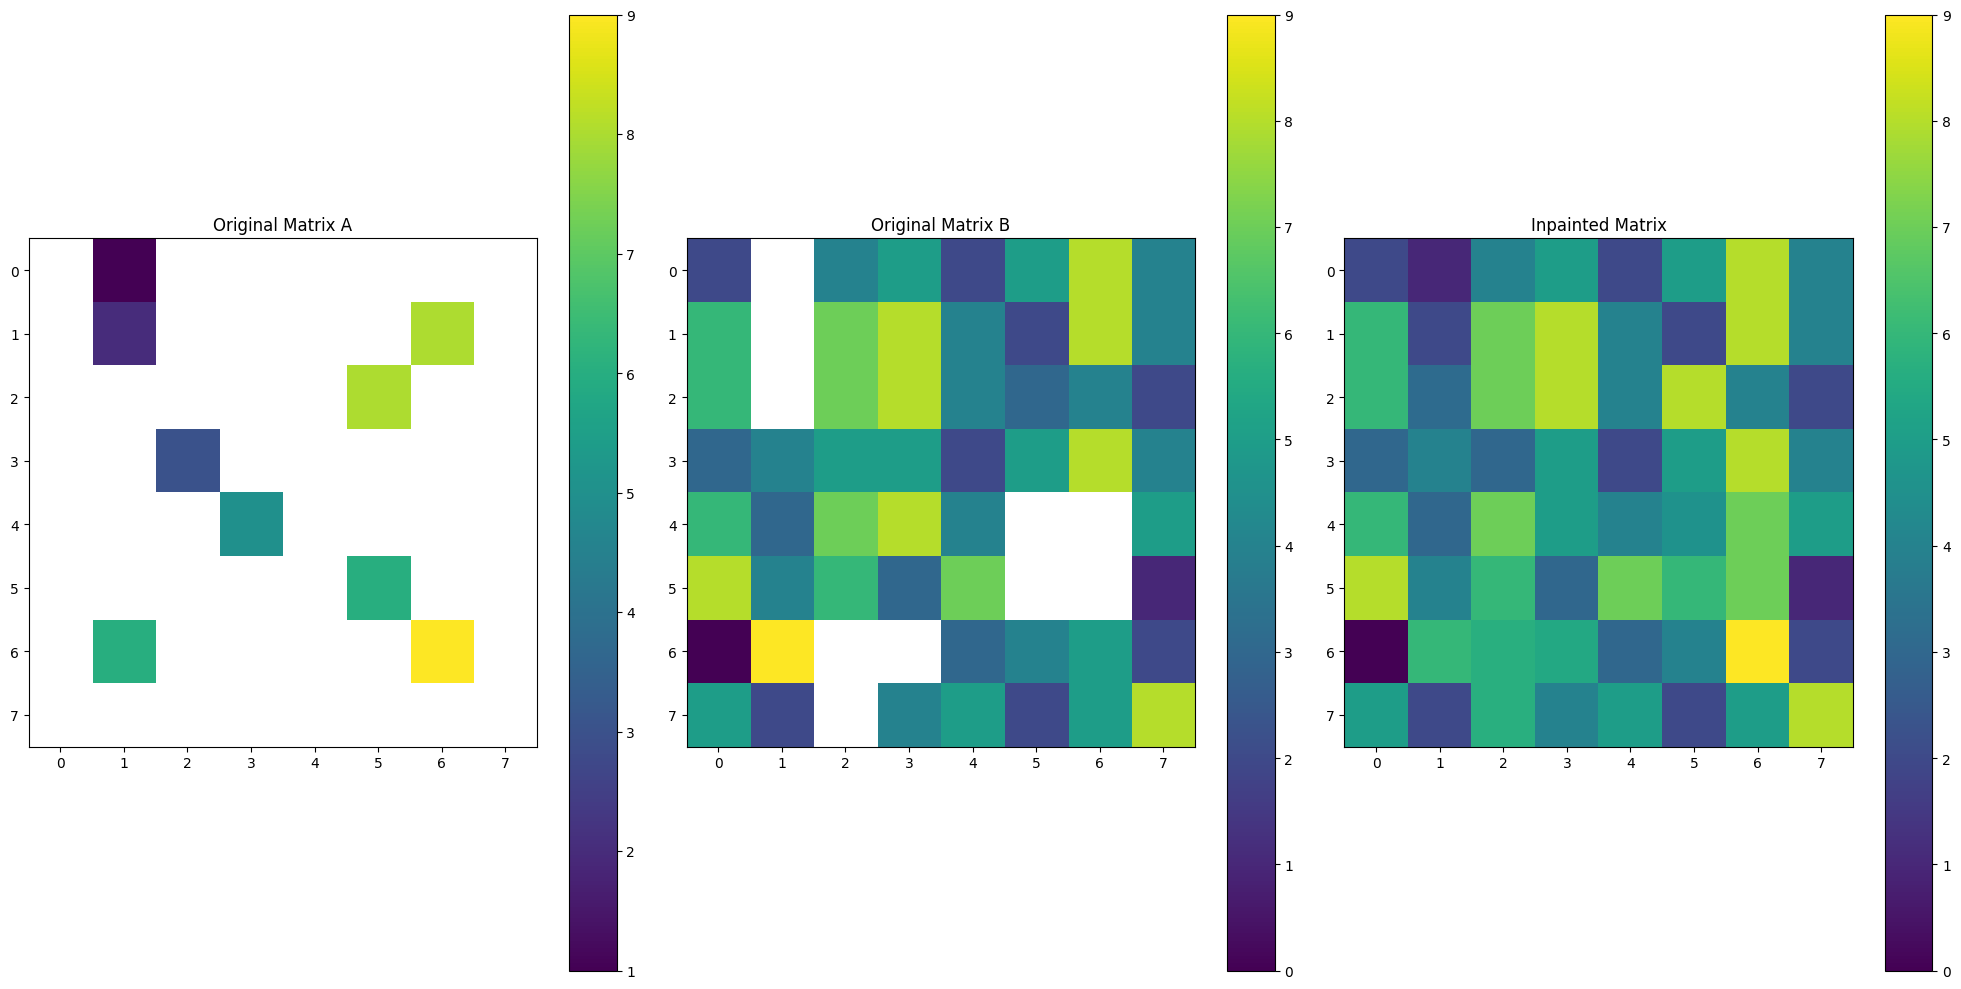

In [29]:
# Plot the original matrix A
plt.subplot(1, 3, 1)
plt.imshow(A, cmap='viridis')
plt.title('Original Matrix A')
plt.colorbar()

# Plot the original matrix B
plt.subplot(1, 3, 2)
plt.imshow(B, cmap='viridis')
plt.title('Original Matrix B')
plt.colorbar()

# Plot the combined inpainted matrix
plt.subplot(1, 3, 3)
plt.imshow(combined, cmap='viridis')
plt.title('Inpainted Matrix')
plt.colorbar()

# Adjust layout
plt.tight_layout()
plt.show()